使用的 seeds: [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574, 5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]



【Stable Red Points】(出现次数 ≥ 1)
eig_idx  count
   eig0     20
   eig1     20

【Stable Orange Points】(出现次数 ≥ 1)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 1)
eig_idx  count
eig3369      2
 eig643      1
eig3879      1
eig3478      1
eig3477      1
eig3220      1
 eig384      1
eig3912      1
eig3804      1
eig3803      1
eig3563      1
eig3562      1
eig3782      1
eig1016      1
eig3781      1
eig1282      1
eig1126      1
eig3290      1
eig3289      1
eig1448      1
eig1132      1
eig1023      1
eig1735      1
eig1584      1
eig3682      1
 eig944      1
eig1165      1
eig1402      1
eig1419      1
eig1366      1
eig1125      1
 eig678      1
eig3977      1
eig3868      1
eig3740      1
eig3475      1
eig2846      1
eig4036      1
eig4001      1
eig3400      1
eig3112      1
eig1344      1
eig3743      1
eig3557      1
eig3556      1
eig1308      1
 eig805      1
eig2064      1
eig1657      1
eig1517      1
 eig993      1
 eig935      1
eig3993      1
eig1105      1
 eig924      1
 eig613    

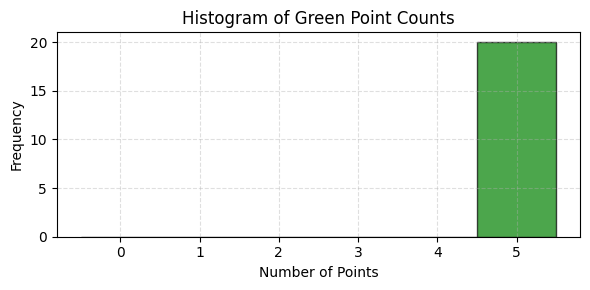

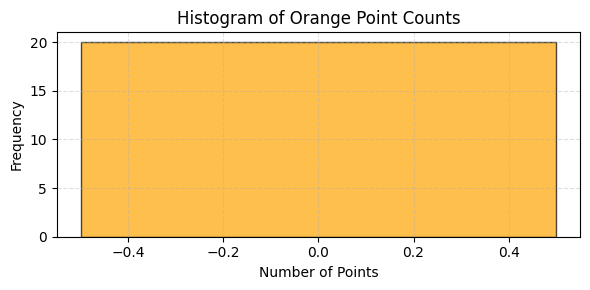

/tmp/ipykernel_319481/3011155207.py:169: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_319481/3011155207.py:169: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


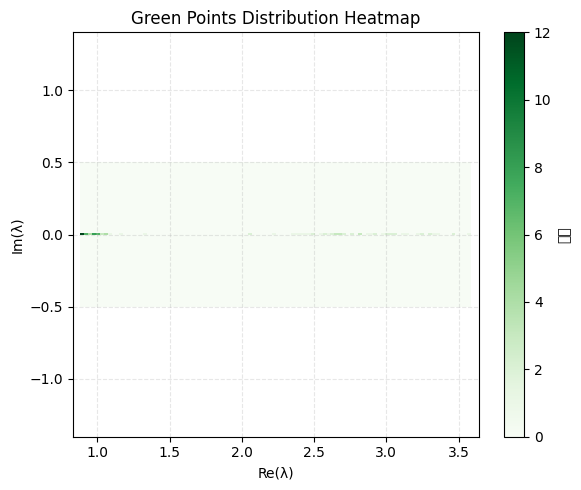

In [4]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 8, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15
jump_margin = 0.1

num_trials = 20
np.random.seed(42)
base_seeds = np.arange(0, 10000, step=500)[:num_trials]
noise = np.random.randint(0, 100, size=num_trials)
seeds = (base_seeds + noise).tolist()
print("使用的 seeds:", seeds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 计数器与记录器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

green_count_list = []
orange_count_list = []
green_coords = []  # 新增：记录绿色点坐标（Re, Im）

# ========== 单轮运行函数 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # ===== 绿色点判别机制（堆积带右跳跃） =====
    real_axis_re = eig_df.loc[np.abs(eig_df["Im"]) < 1e-6, "Re"].values
    if len(real_axis_re) >= 100:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta

        green_mask = (
            (np.abs(eig_df["Im"]) < 1e-6) &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh + jump_margin)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1

    green_count_list.append(len(green_pts))
    orange_count_list.append(len(orange_pts))

    # ✅ 新增：记录绿色点坐标
    green_coords.extend(list(zip(green_pts["Re"], green_pts["Im"])))

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印稳定谱点 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)

# ========== 显示绿色/橙色数量直方分布 ==========
green_series = pd.Series(green_count_list, name="GreenCount")
orange_series = pd.Series(orange_count_list, name="OrangeCount")

print("\n[绿色点数量直方分布 across trials]")
print(green_series.value_counts().sort_index().to_string())

print("\n[橙色点数量直方分布 across trials]")
print(orange_series.value_counts().sort_index().to_string())

def plot_histogram(counts, title, color):
    plt.figure(figsize=(6, 3))
    plt.hist(counts, bins=np.arange(-0.5, max(counts) + 1.5, 1), edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Number of Points")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_histogram(green_count_list, "Histogram of Green Point Counts", "green")
plot_histogram(orange_count_list, "Histogram of Orange Point Counts", "orange")

# ========== 新增：绿色点坐标热力图 ==========
def plot_green_point_heatmap(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]

    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap")
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ✅ 调用可视化函数
plot_green_point_heatmap(green_coords)



【标准一】绿色点跨轮次“同一网格点”出现次数（按频次降序，显示前20条）：
 Re_q  Im_q  count
0.905   0.0      6
0.890   0.0      3
2.770   0.0      2
3.245   0.0      2
3.040   0.0      2
0.985   0.0      2
2.810   0.0      2
0.915   0.0      2
0.955   0.0      2
0.930   0.0      2
0.975   0.0      2
0.995   0.0      2
2.915   0.0      2
3.015   0.0      2
2.065   0.0      2
1.010   0.0      2
0.970   0.0      2
2.640   0.0      2
1.000   0.0      2
1.065   0.0      2

【标准一结论】是否存在近似固定的绿色点（同一网格点在 ≥80% 轮次出现）：False

【标准二】在 A 区间 [0.95, 1.05] 内出现 ≥2 个绿色点的轮次：8/20，比例=0.40

【标准三】每轮 A/B 区绿色点数量：
 seed  A_count  B_count
   51        0        0
  592        2        0
 1014        0        0
 1571        0        0
 2060        0        0
 2520        2        0
 3082        1        0
 3586        1        0
 4074        1        0
 4574        2        0
 5087        0        0
 5599        2        0
 6023        2        0
 6502        2        0
 7021        2        0
 7552        0        0
 8001        2        0
 8587     

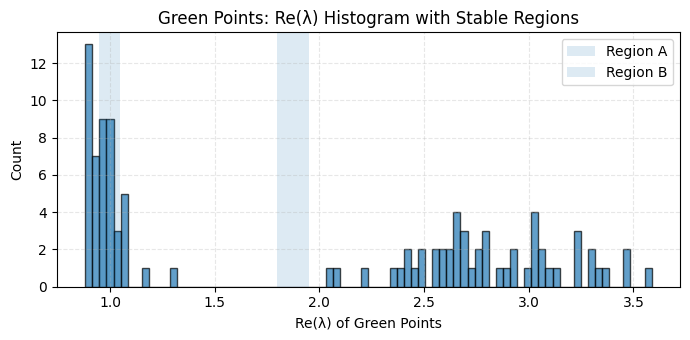

/tmp/ipykernel_319481/108180099.py:134: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_319481/108180099.py:134: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


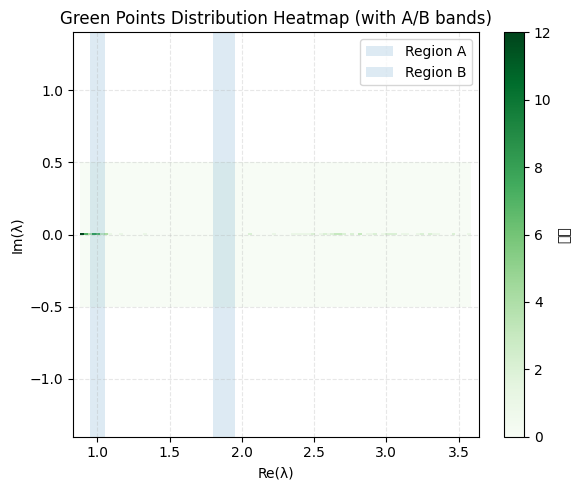


========== 稳定性评估小结 ==========
标准一：按网格化坐标统计跨轮次“同一绿色点”的出现次数；结果一般不会出现绝对固定点（与论文叙述一致：点级重现假设不成立）。
标准二：超过半数轮次 (>10.0) 在 A 区间出现 ≥2 个绿色点？ -> 8 轮，比例 0.40
标准三：A/B 区计数显示 A 区更稳定；若需子空间恢复评估，请优先使用上文列出的 A_ge2_seeds 对应轮次。


In [5]:
# ======= 新增：评估参数（容差与网格步长） =======
real_tol = 1e-6           # 认为“近似实轴”的虚部阈值
bin_width_re = 0.005      # 绿色点坐标网格化（实部）步长，用于“标准一”的跨轮次计数
bin_width_im = 0.005      # 绿色点坐标网格化（虚部）步长

# 稳定区间（标准二/三）
A_min, A_max = 0.95, 1.05
B_min, B_max = 1.80, 1.95

# ======= 工具函数：坐标网格化（用于标准一） =======
def quantize_coord(x, w):
    return np.round(x / w) * w

def bucketize_point(re, im, w_re, w_im):
    return (quantize_coord(re, w_re), quantize_coord(im, w_im))

# ======= 新增：跨轮次绿色点“桶”计数（标准一） =======
green_bucket_counter = Counter()
# 每轮 A/B 区绿色点计数（标准三）
per_trial_counts = []  # list of dicts：{"seed":..., "A_count":..., "B_count":..., "A_coords":..., "B_coords":...}
# 每轮 A 区是否达到 ≥2（标准二）
A_ge2_flags = []

# ======= 修改：在 run_single_trial 内部，我们已把 green_coords 追加了 (Re, Im)
# 这里在主循环结束后，做三套标准的统计 =======

# ---- 标准一：同一点跨轮次重现（用网格化坐标近似“同一点”） ----
for (re, im) in green_coords:
    key = bucketize_point(re, im, bin_width_re, bin_width_im)
    green_bucket_counter[key] += 1

# 构造 DataFrame 便于查看跨轮次高频“同一点”
bucket_items = []
for (re_q, im_q), cnt in green_bucket_counter.items():
    bucket_items.append({"Re_q": re_q, "Im_q": im_q, "count": cnt})
bucket_df = pd.DataFrame(bucket_items).sort_values("count", ascending=False)

print("\n【标准一】绿色点跨轮次“同一网格点”出现次数（按频次降序，显示前20条）：")
print(bucket_df.head(20).to_string(index=False) if not bucket_df.empty else "无绿色点可统计")

# 粗判结论（是否存在明显“固定点”）
fixed_like_exists = (not bucket_df.empty) and (bucket_df["count"].max() >= num_trials * 0.8)
print(f"\n【标准一结论】是否存在近似固定的绿色点（同一网格点在 ≥80% 轮次出现）：{fixed_like_exists}")

# ---- 标准二 & 三：按稳定区间统计 ----
# 我们按“每轮”的绿色点坐标重建（需要把 green_coords 按 trial 切片）
# 为此在 run_single_trial 中增加每轮绿色点数量 green_count_list，这里利用它切片
trial_slices = []
start = 0
for k in range(num_trials):
    cnt = green_count_list[k]
    trial_slices.append((start, start + cnt))
    start += cnt

A_ge2 = 0
A_ge2_seeds = []
regionA_coords_all = []
regionB_coords_all = []

for k, (lo, hi) in enumerate(trial_slices):
    seed_k = seeds[k]
    coords_k = green_coords[lo:hi]
    # A/B 区筛选（近似实轴）
    Ak = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (A_min <= re <= A_max))]
    Bk = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (B_min <= re <= B_max))]
    per_trial_counts.append({
        "seed": seed_k,
        "A_count": len(Ak),
        "B_count": len(Bk),
        "A_coords": Ak,
        "B_coords": Bk,
    })
    regionA_coords_all.extend(Ak)
    regionB_coords_all.extend(Bk)

    # 标准二：本轮 A 区是否有 ≥2 个绿色点
    flag = (len(Ak) >= 2)
    A_ge2_flags.append(flag)
    if flag:
        A_ge2 += 1
        A_ge2_seeds.append(seed_k)

ratio_A_ge2 = A_ge2 / num_trials
print(f"\n【标准二】在 A 区间 [{A_min}, {A_max}] 内出现 ≥2 个绿色点的轮次：{A_ge2}/{num_trials}，比例={ratio_A_ge2:.2f}")

# ---- 标准三：每轮 A/B 区计数与“进入子空间评估”的种子清单 ----
per_trial_df = pd.DataFrame(per_trial_counts)
print("\n【标准三】每轮 A/B 区绿色点数量：")
print(per_trial_df[["seed", "A_count", "B_count"]].to_string(index=False))

if len(A_ge2_seeds) > 0:
    print("\n【标准三结论】满足“A 区稳定出现两个及以上绿色点”的轮次 seeds（建议进入子空间恢复评估）：")
    print(A_ge2_seeds)
else:
    print("\n【标准三结论】未出现满足“A 区 ≥2”条件的轮次。")

# ======= 附：更直观的可视化 =======
# 1) 绿色点 Re 的一维分布（标注 A/B 区）
re_all = np.array([c[0] for c in green_coords]) if len(green_coords) > 0 else np.array([])
plt.figure(figsize=(7, 3.5))
if len(re_all) > 0:
    plt.hist(re_all, bins=80, edgecolor='black', alpha=0.7, density=False)
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.xlabel("Re(λ) of Green Points")
    plt.ylabel("Count")
    plt.title("Green Points: Re(λ) Histogram with Stable Regions")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无绿色点，跳过 Re(λ) 直方图绘制。")

# 2) 绿色点二维热力图（你已有），这里再补上 A/B 区间的可视化边界线
def plot_green_point_heatmap_with_bands(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]
    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap (with A/B bands)")
    # 画出 A/B 竖带
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_green_point_heatmap_with_bands(green_coords)

# ======= 小结（打印型） =======
print("\n========== 稳定性评估小结 ==========")
print("标准一：按网格化坐标统计跨轮次“同一绿色点”的出现次数；"
      "结果一般不会出现绝对固定点（与论文叙述一致：点级重现假设不成立）。")
print(f"标准二：超过半数轮次 (>{num_trials/2}) 在 A 区间出现 ≥2 个绿色点？ -> {A_ge2} 轮，比例 {ratio_A_ge2:.2f}")
print("标准三：A/B 区计数显示 A 区更稳定；若需子空间恢复评估，请优先使用上文列出的 A_ge2_seeds 对应轮次。")


使用的 seeds: [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574, 5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]

【Stable Red Points】(出现次数 ≥ 1)
eig_idx  count
   eig0     20
   eig1     18
   eig2      1
   eig5      1

【Stable Orange Points】(出现次数 ≥ 1)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 1)
eig_idx  count
eig1873      2
eig3610      2
eig3443      2
eig1606      2
eig3749      1
eig1001      1
eig1337      1
eig3351      1
eig3694      1
eig1566      1
eig1636      1
eig3912      1
 eig927      1
eig3284      1
eig3752      1
eig1043      1
eig1296      1
eig2021      1
eig3662      1
eig3541      1
eig1314      1
eig3791      1
eig3869      1
eig2996      1
eig3342      1
eig2790      1
eig3707      1
eig3290      1
eig1072      1
eig1684      1
eig1848      1
eig1464      1
eig3864      1
eig3748      1
eig3146      1
eig3592      1
eig3779      1
 eig560      1
eig1030      1
eig1297      1
eig1715      1
eig1975      1
eig1184      1
eig1462      1
eig2993      1
ei

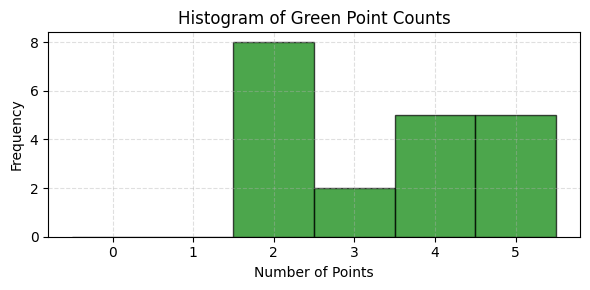

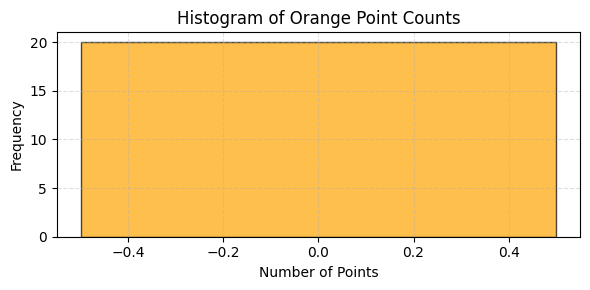

/tmp/ipykernel_79145/3196229833.py:169: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_79145/3196229833.py:169: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


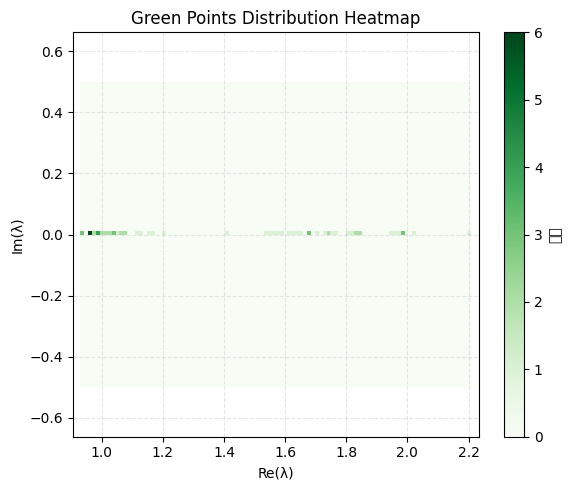

In [3]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict
import matplotlib.pyplot as plt

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 3, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15
jump_margin = 0.1

# ========== 使用你给定的固定种子 ==========
seeds = [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574,
         5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]
num_trials = len(seeds)
print("使用的 seeds:", seeds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 计数器与记录器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

green_count_list = []
orange_count_list = []
green_coords = []  # 记录绿色点坐标（Re, Im）

# ========== 单轮运行函数 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # ===== 绿色点判别机制（堆积带右跳跃） =====
    real_axis = np.abs(eig_df["Im"]) < 1e-6
    real_axis_re = eig_df.loc[real_axis, "Re"].values
    if len(real_axis_re) >= 100 and np.var(real_axis_re) > 0:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta

        green_mask = (
            real_axis &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh + jump_margin)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1

    green_count_list.append(len(green_pts))
    orange_count_list.append(len(orange_pts))

    # 记录绿色点坐标
    green_coords.extend(list(zip(green_pts["Re"], green_pts["Im"])))

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印稳定谱点 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)

# ========== 显示绿色/橙色数量直方分布 ==========
green_series = pd.Series(green_count_list, name="GreenCount")
orange_series = pd.Series(orange_count_list, name="OrangeCount")

print("\n[绿色点数量直方分布 across trials]")
print(green_series.value_counts().sort_index().to_string())

print("\n[橙色点数量直方分布 across trials]")
print(orange_series.value_counts().sort_index().to_string())

def plot_histogram(counts, title, color):
    plt.figure(figsize=(6, 3))
    plt.hist(counts, bins=np.arange(-0.5, max(counts) + 1.5, 1), edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Number of Points")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_histogram(green_count_list, "Histogram of Green Point Counts", "green")
plot_histogram(orange_count_list, "Histogram of Orange Point Counts", "orange")

# ========== 绿色点坐标热力图 ==========
def plot_green_point_heatmap(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]

    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap")
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 可视化
plot_green_point_heatmap(green_coords)



【标准一】绿色点跨轮次“同一网格点”出现次数（按频次降序，显示前20条）：
 Re_q  Im_q  count
1.035   0.0      5
1.000   0.0      3
0.990   0.0      3
1.025   0.0      2
2.025   0.0      2
1.985   0.0      2
0.970   0.0      2
1.020   0.0      2
0.950   0.0      2
1.010   0.0      2
2.270   0.0      1
1.725   0.0      1
1.770   0.0      1
1.970   0.0      1
1.045   0.0      1
0.965   0.0      1
2.355   0.0      1
1.865   0.0      1
0.960   0.0      1
1.050   0.0      1

【标准一结论】是否存在近似固定的绿色点（同一网格点在 ≥80% 轮次出现）：False

【标准二】在 A 区间 [0.95, 1.05] 内出现 ≥2 个绿色点的轮次：11/20，比例=0.55

【标准三】每轮 A/B 区绿色点数量：
 seed  A_count  B_count
   51        2        0
  592        2        0
 1014        2        0
 1571        2        1
 2060        0        1
 2520        1        1
 3082        2        0
 3586        1        0
 4074        0        0
 4574        2        0
 5087        0        0
 5599        0        1
 6023        2        0
 6502        2        1
 7021        1        0
 7552        2        0
 8001        1        0
 8587    

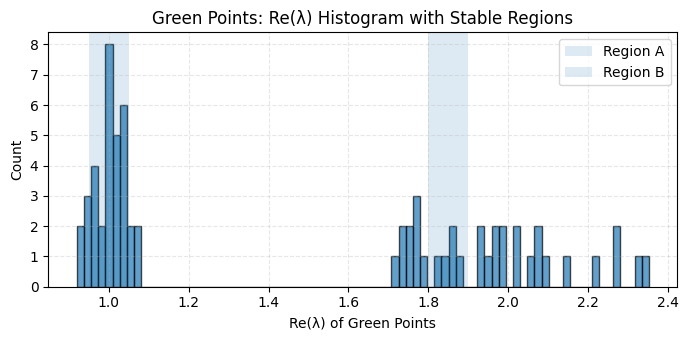

/tmp/ipykernel_168827/1037713889.py:134: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_168827/1037713889.py:134: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


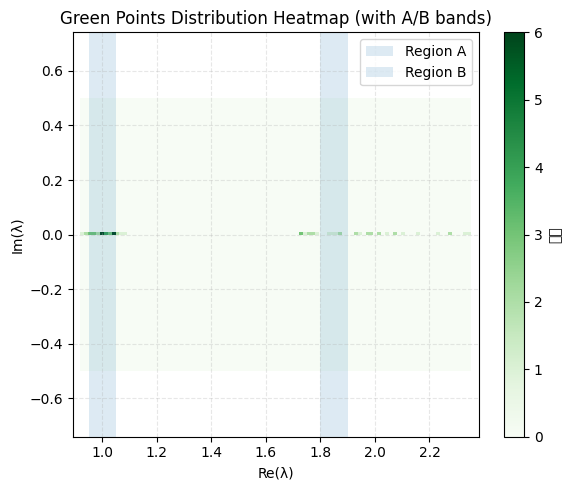


========== 稳定性评估小结 ==========
标准一：按网格化坐标统计跨轮次“同一绿色点”的出现次数；结果一般不会出现绝对固定点（与论文叙述一致：点级重现假设不成立）。
标准二：超过半数轮次 (>10.0) 在 A 区间出现 ≥2 个绿色点？ -> 11 轮，比例 0.55
标准三：A/B 区计数显示 A 区更稳定；若需子空间恢复评估，请优先使用上文列出的 A_ge2_seeds 对应轮次。


In [4]:
# ======= 新增：评估参数（容差与网格步长） =======
real_tol = 1e-6           # 认为“近似实轴”的虚部阈值
bin_width_re = 0.005      # 绿色点坐标网格化（实部）步长，用于“标准一”的跨轮次计数
bin_width_im = 0.005      # 绿色点坐标网格化（虚部）步长

# 稳定区间（标准二/三）
A_min, A_max = 0.95, 1.05
B_min, B_max = 1.8, 1.9

# ======= 工具函数：坐标网格化（用于标准一） =======
def quantize_coord(x, w):
    return np.round(x / w) * w

def bucketize_point(re, im, w_re, w_im):
    return (quantize_coord(re, w_re), quantize_coord(im, w_im))

# ======= 新增：跨轮次绿色点“桶”计数（标准一） =======
green_bucket_counter = Counter()
# 每轮 A/B 区绿色点计数（标准三）
per_trial_counts = []  # list of dicts：{"seed":..., "A_count":..., "B_count":..., "A_coords":..., "B_coords":...}
# 每轮 A 区是否达到 ≥2（标准二）
A_ge2_flags = []

# ======= 修改：在 run_single_trial 内部，我们已把 green_coords 追加了 (Re, Im)
# 这里在主循环结束后，做三套标准的统计 =======

# ---- 标准一：同一点跨轮次重现（用网格化坐标近似“同一点”） ----
for (re, im) in green_coords:
    key = bucketize_point(re, im, bin_width_re, bin_width_im)
    green_bucket_counter[key] += 1

# 构造 DataFrame 便于查看跨轮次高频“同一点”
bucket_items = []
for (re_q, im_q), cnt in green_bucket_counter.items():
    bucket_items.append({"Re_q": re_q, "Im_q": im_q, "count": cnt})
bucket_df = pd.DataFrame(bucket_items).sort_values("count", ascending=False)

print("\n【标准一】绿色点跨轮次“同一网格点”出现次数（按频次降序，显示前20条）：")
print(bucket_df.head(20).to_string(index=False) if not bucket_df.empty else "无绿色点可统计")

# 粗判结论（是否存在明显“固定点”）
fixed_like_exists = (not bucket_df.empty) and (bucket_df["count"].max() >= num_trials * 0.8)
print(f"\n【标准一结论】是否存在近似固定的绿色点（同一网格点在 ≥80% 轮次出现）：{fixed_like_exists}")

# ---- 标准二 & 三：按稳定区间统计 ----
# 我们按“每轮”的绿色点坐标重建（需要把 green_coords 按 trial 切片）
# 为此在 run_single_trial 中增加每轮绿色点数量 green_count_list，这里利用它切片
trial_slices = []
start = 0
for k in range(num_trials):
    cnt = green_count_list[k]
    trial_slices.append((start, start + cnt))
    start += cnt

A_ge2 = 0
A_ge2_seeds = []
regionA_coords_all = []
regionB_coords_all = []

for k, (lo, hi) in enumerate(trial_slices):
    seed_k = seeds[k]
    coords_k = green_coords[lo:hi]
    # A/B 区筛选（近似实轴）
    Ak = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (A_min <= re <= A_max))]
    Bk = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (B_min <= re <= B_max))]
    per_trial_counts.append({
        "seed": seed_k,
        "A_count": len(Ak),
        "B_count": len(Bk),
        "A_coords": Ak,
        "B_coords": Bk,
    })
    regionA_coords_all.extend(Ak)
    regionB_coords_all.extend(Bk)

    # 标准二：本轮 A 区是否有 ≥2 个绿色点
    flag = (len(Ak) >= 2)
    A_ge2_flags.append(flag)
    if flag:
        A_ge2 += 1
        A_ge2_seeds.append(seed_k)

ratio_A_ge2 = A_ge2 / num_trials
print(f"\n【标准二】在 A 区间 [{A_min}, {A_max}] 内出现 ≥2 个绿色点的轮次：{A_ge2}/{num_trials}，比例={ratio_A_ge2:.2f}")

# ---- 标准三：每轮 A/B 区计数与“进入子空间评估”的种子清单 ----
per_trial_df = pd.DataFrame(per_trial_counts)
print("\n【标准三】每轮 A/B 区绿色点数量：")
print(per_trial_df[["seed", "A_count", "B_count"]].to_string(index=False))

if len(A_ge2_seeds) > 0:
    print("\n【标准三结论】满足“A 区稳定出现两个及以上绿色点”的轮次 seeds（建议进入子空间恢复评估）：")
    print(A_ge2_seeds)
else:
    print("\n【标准三结论】未出现满足“A 区 ≥2”条件的轮次。")

# ======= 附：更直观的可视化 =======
# 1) 绿色点 Re 的一维分布（标注 A/B 区）
re_all = np.array([c[0] for c in green_coords]) if len(green_coords) > 0 else np.array([])
plt.figure(figsize=(7, 3.5))
if len(re_all) > 0:
    plt.hist(re_all, bins=80, edgecolor='black', alpha=0.7, density=False)
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.xlabel("Re(λ) of Green Points")
    plt.ylabel("Count")
    plt.title("Green Points: Re(λ) Histogram with Stable Regions")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无绿色点，跳过 Re(λ) 直方图绘制。")

# 2) 绿色点二维热力图（你已有），这里再补上 A/B 区间的可视化边界线
def plot_green_point_heatmap_with_bands(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]
    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap (with A/B bands)")
    # 画出 A/B 竖带
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_green_point_heatmap_with_bands(green_coords)

# ======= 小结（打印型） =======
print("\n========== 稳定性评估小结 ==========")
print("标准一：按网格化坐标统计跨轮次“同一绿色点”的出现次数；"
      "结果一般不会出现绝对固定点（与论文叙述一致：点级重现假设不成立）。")
print(f"标准二：超过半数轮次 (>{num_trials/2}) 在 A 区间出现 ≥2 个绿色点？ -> {A_ge2} 轮，比例 {ratio_A_ge2:.2f}")
print("标准三：A/B 区计数显示 A 区更稳定；若需子空间恢复评估，请优先使用上文列出的 A_ge2_seeds 对应轮次。")


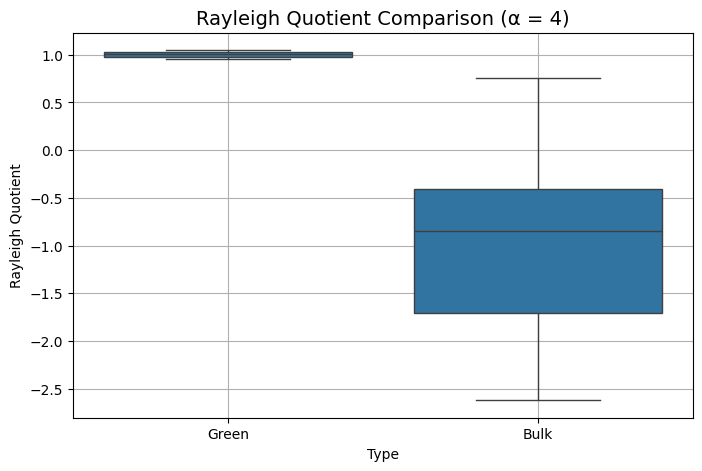

In [1]:
import numpy as np
import torch
from scipy.special import kv as besselk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 4, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 数据生成 ==========
torch.manual_seed(0)
np.random.seed(0)
W_star = torch.randn(d, p, device=device)
X = torch.randn(n, d, device=device) / np.sqrt(d)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ========== 构造 G(y) ==========
abs_y = torch.abs(y)
abs_y_np = abs_y.cpu().numpy()
K0 = torch.from_numpy(besselk(0, abs_y_np)).to(device)
K1 = torch.from_numpy(besselk(1, abs_y_np)).to(device)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[torch.isnan(lambda_y)] = 0

G_y = torch.zeros((n, p, p), device=device)
G_y[:, 0, 0] = lambda_y
G_y[:, 1, 1] = lambda_y

# ========== 构造谱矩阵 ==========
L = torch.zeros((p * d, p * d), device=device)
for i in range(n):
    xi = X[i].view(d, 1)
    xi_xt = xi @ xi.T
    L += torch.kron(G_y[i], xi_xt)

# ========== 谱分解 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 绿色点筛选 ==========
real_parts = eigvals_np.real
green_mask = (real_parts > 0.95) & (real_parts < 1.05)
green_vecs = eigvecs_np[:, green_mask]

# ========== Bulk 点筛选 ==========
# 假设 Bulk 在谱堆积带中心区，这里取 Re(λ) < 0.9
bulk_mask = (real_parts < 0.9)
bulk_vecs = eigvecs_np[:, bulk_mask]

# 随机选取与 Green 数量相同的 Bulk 向量
if bulk_vecs.shape[1] >= green_vecs.shape[1]:
    bulk_indices = np.random.choice(bulk_vecs.shape[1], green_vecs.shape[1], replace=False)
    bulk_vecs = bulk_vecs[:, bulk_indices]

# ========== Rayleigh 商分析 ==========
L_np = L.cpu().numpy()
R_green, R_bulk = [], []

for v in green_vecs.T:
    v = v / np.linalg.norm(v)
    R = (v.T @ L_np @ v) / np.linalg.norm(v) ** 2
    R_green.append(R.real)

for v in bulk_vecs.T:
    v = v / np.linalg.norm(v)
    R = (v.T @ L_np @ v) / np.linalg.norm(v) ** 2
    R_bulk.append(R.real)

# ========== 可视化 ==========
df = pd.DataFrame({
    'Rayleigh Quotient': R_green + R_bulk,
    'Type': ['Green'] * len(R_green) + ['Bulk'] * len(R_bulk)
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Type', y='Rayleigh Quotient')
plt.title(f'Rayleigh Quotient Comparison (α = {alpha})', fontsize=14)
plt.grid(True)
plt.show()
